# Now Hiring Andrews

D2D CRC is hiring Data Scientists! Requirements:
- Python, R, or similar
- Knowledge of Machine Learning
- Name must be **Andrew**, **Nick** or **Sarah**...

We work in an office with 40 staff. We have 3 Andrews, 2 Nicks, 2 Sarahs, 2 Grants, and 2 Scotts!

On the surface this seems very unlikely, but what's the actual probability? Some names are much more popular than others, so could it be more common than intuition tells us. Is something like the [birthday paradox](https://en.wikipedia.org/wiki/Birthday_problem) happening?

The maths grows complicated quickly when you consider that some names aren't uniformly distributed, some names remain popular through the decades, while others follow temporary trends, and the demographic we hire is not representative of the general population. The non-uniform nature of the distribution makes a programmatic approach appropriate.

A public dataset of name frequencies wasn't available for Australia, but I did find one for the US, with name frequencies for all SSN holders from the years 1880 - 2013. The names will vary between Australia and the US, but it shouldn't affect the result significantly provided the distributions are similar.

The data is provided in a single zip file `names.zip` containing a set of csv files named `yobxxxx.txt`, where `xxxx` is the year. Each row has a `name,gender,count` for that year e.g. `Mary,F,7065`

Let's sample some of the data for 1984...


In [1]:
import zipfile
import numpy as np
import pandas as pd

# Load one of the files into a dataframe and display a sample
df = pd.read_csv(zipfile.ZipFile('names.zip').open('yob1984.txt'), sep=',', header=None, names=['name','gender','count'], dtype={'count': np.float64})
print df.sample(10)


            name gender  count
2854      Carlye      F   31.0
12605    Carlton      M  366.0
12120    Virgina      F    5.0
5494      Shruti      F   13.0
18865     Hassen      M    5.0
1316      Gracie      F   93.0
2735    Christyn      F   33.0
4512   Charmayne      F   16.0
4267       Nadja      F   18.0
12586       Greg      M  386.0


Reviewing the sample, we can see that some names are very popular while others are barely used.

If we sort by the count and plot the top 1000 names it's easy to see that each year is dominated by ~100 names. The long tail of less popular names extends out for 10's of thousands more.

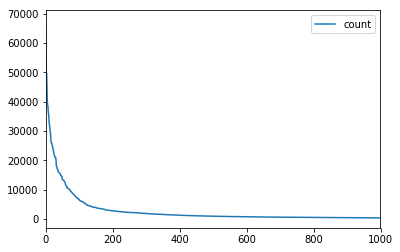

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot name distribution for the sample year
df = df.sort_values(['count'], ascending=False)
df.head(1000).reset_index().plot(y='count', use_index=True)


## Merging Distributions

A cursory look across years shows that the popular names vary year-by-year, with a handful of names remaining popular across decades (e.g. Jessica, Daniel).

My goal is to build a distribution I can sample for random names that reflects the demographic we hire from. To do this properly I need to merge the distributions for individual years into a single distribution.

The skillset and degrees we hire for tend to attract a younger workforce - I estimate the median age is late 20's, with more younger staff than older. We only hire engineers with University degrees, so the youngest staff we have are ~21.

I've modelled this as a chi-squared distribution, plotted below. It starts at 21, peaks in late 20s and tails off to retirement. I'll use this chi-squared distribution to weight contributions for individual years.


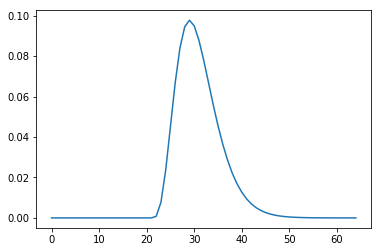

In [3]:
from scipy import stats

# Assume a chi-squared distribution of ages
# - 21yr cutoff (graduates)
# - mean ~30
# - long tail to retirement
ageDistribution = np.empty(65)
for i in range(0,64):
    ageDistribution[i]=stats.chi2.pdf(i-21, 10)
plt.plot(ageDistribution)
plt.show()


The counts for each year are loaded into DataFrames, weighted using the chi-squared distribution and merged (summing the count) to give a single distribution of names.

In [4]:
import zipfile

merged = pd.DataFrame(columns=['name', 'gender', 'count'])

z = zipfile.ZipFile('names.zip')
for filename in z.namelist():
    # Sample filename: yob1980.txt
    year = filename[3:7]
    try:
        if int(year) < (2017 - 21):
            df = pd.read_csv(z.open(filename), sep=',', header=None, names=['name','gender','count'], dtype={'count': np.int32})
            # Weight for age probability
            df['count'] = df['count'].apply(lambda count: count*ageDistribution[2017-int(year)])
            
            # Merge into a single distribution
            merged = pd.concat([df, merged]).groupby(['name', 'gender'], as_index=False)['count'].sum()
    except:
        pass
z.close()

merged = merged.sort_values(['count'], ascending=False)


Viewing the top names in this distribution tells us the most likely names we'll hire. Already we can see **Andrew** and **Sarah** in the list. We also have a Chris, Matt and Dave in our team, so things are looking promising...

In [5]:
print merged.head(20)

              name gender         count
39095      Michael      M  64513.588913
10210  Christopher      M  52966.007838
25554      Jessica      F  44825.062864
38132      Matthew      M  43885.933866
26721       Joshua      M  38480.012620
4354        Ashley      F  38048.532879
25070     Jennifer      F  36789.904074
13136        David      M  36457.944713
23459        James      M  34292.861273
2044        Amanda      F  34092.645447
12345       Daniel      M  33511.804712
26109         John      M  30947.101549
46283       Robert      M  30801.530949
2624        Andrew      M  29518.285341
26670       Joseph      M  29235.935695
27241       Justin      M  27430.362690
47318         Ryan      M  27301.252181
48067        Sarah      F  25852.509883
59227      William      M  24591.045765
24283        Jason      M  23742.710833


## Gender Imbalance

We're not quite finished yet - we need to consider the significant gender imbalance in our industry. Recent estimates put the percentage of females in engineering roles are a sobering [16%](https://business.linkedin.com/talent-solutions/blog/2014/03/women-in-engineering-the-sobering-stats).


We'll weight the female names lower as a result, as it's far less likely we'll have female applicants. We have a few non-engineering roles so we'll use a value of 20%. This step is important because looking at the list above it seems that male names are more common. Maybe there's less diversity in male names.

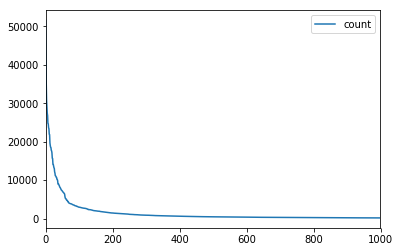

In [6]:
merged['count'] = merged.apply(lambda row: row['count']*(1-0.2) if row['gender'] == 'M' else row['count']*0.2, axis=1)
weighted = merged.sort_values(['count'], ascending=False)

weighted = weighted.sort_values(['count'], ascending=False)
weighted.head(1000).reset_index().plot(y='count', use_index=True)

This distribution looks steeper than our original curve, so the enduring names that remain popular across decades and the gender imbalance have had  an affect. The distribution is now dominated by ~50 names.

Lets look at how dominant they are...

In [10]:
# Calculate the top 50 names as a % of the total population
percent = 100*sum(weighted.head(50)['count'])/sum(weighted['count'])
print '{:0.2f}%'.format(percent)

44.55%


So almost half the distribution is the top 50 names.

## Sampling

Now we'll build a function to sample our distribution for random names. Before we do this we'll normalise the counts to convert them to probabilities.

There's some interesting data structures for sampling discrete distributions e.g. balanced binary trees, but `numpy` has a discreet distribution sampler built in, so let's just use that.

In [11]:
# Drop gender and normalise probabilities
normalised = weighted.drop('gender', axis=1)
normalised.columns = ['name','probability']
total = sum(normalised['probability'])
normalised['probability'] = normalised['probability'].apply(lambda prob: prob/total)


def sample(elements, probabilities, num):
    # Just use numpy's discrete distribution sampler
    return np.random.choice(elements, num, p=probabilities)


# Try sampling some random names
randomNames = sample(normalised['name'], normalised['probability'], 40)
print randomNames

['James' 'Vanessa' 'Chelsea' 'Jeremy' 'Anthony' 'Jonathan' 'Thomas'
 'Randolph' 'Maureen' 'Timothy' 'Jonathan' 'Brian' 'Justin' 'Joseph'
 'Stefan' 'Jacob' 'Jose' 'William' 'Vincent' 'Ryan' 'Aaron' 'Michael'
 'Christopher' 'Francisco' 'Loren' 'Jessica' 'Jevon' 'Gregory' 'Cary'
 'John' 'Sarah' 'Sharif' 'Kenneth' 'Shelley' 'Zachary' 'Alexander' 'Luke'
 'Robert' 'Brian' 'Terrance']


We also need a function to count repeated names. For simplicity, we'll treat all repeated names as equal (pairs, triplets etc).

In [12]:
from collections import Counter

def countRepeats(elements):
    # Count the names
    nameCounts = Counter(elements)
    # Count the counts
    countCounts = Counter(nameCounts.values())
    # Sum the repeats
    repeats = 0
    for a,b in countCounts.items():
        if a > 1:
            repeats = repeats + b
    return repeats

print countRepeats(randomNames)

2


## Lots of Samples

Now we'll count the repeats for many of random samples.

In [13]:
c = Counter()
iterations = 10000
orgSize = 40
for i in range(1,iterations):
    repeats = countRepeats(sample(normalised['name'], normalised['probability'], orgSize))
    c[repeats] += 1
    
print sorted(c.items())

[(0, 185), (1, 909), (2, 2093), (3, 2757), (4, 2203), (5, 1209), (6, 490), (7, 122), (8, 28), (9, 3)]


We can use the counts to get an approximate probability for the 5 repeated names in our organisation...

In [14]:
print sorted(c.items())[5][1]/float(iterations)

0.1209


It looks like the 5 duplicate names we have in our organisation isn't as rare as intuition tells us. It will actually occur >10% of the time.

## That Seems High...

I started to suspect there was something wrong with the data. Printing the least popular names from our original data set shows that they all have a count of 5. It turns out names with less than 5 instances are omitted from the set for privacy reasons. The long tail isn't long enough.

In [15]:
print df.tail(10)

          name gender  count
2074  Schuyler      M      5
2075    Sebron      M      5
2076      Shed      M      5
2077       Sie      M      5
2078   Tilford      M      5
2079     Titus      M      5
2080     Toney      M      5
2081     Verna      M      5
2082    Winnie      M      5
2083  Winthrop      M      5


Lets check the 1984 sample year. There were 3,669,141 births in the US in 1984. How many are in our data set?

In [16]:
df = pd.read_csv(zipfile.ZipFile('names.zip').open('yob1984.txt'), sep=',', header=None, names=['name','gender','count'], dtype={'count': np.float64})
total = sum(df['count'])
actual = 3669141 
delta = actual - total
percent = delta/float(actual)

print 'Total: {}'.format(total)
print 'Missing: {:0.2f}%'.format(percent*100)

Total: 3486443.0
Missing: 4.98%


It turns out we're only missing ~5% of names, all of which would have a very low probability of occurring. Including these would not change the results significantly.

## Exporing Further

What are the probabilities of having *at least one* repeated name for different organisation sizes? We can work out the probability of having any number of repeated names as 1 - the probability of no repeats, then plot the results for different group sizes.

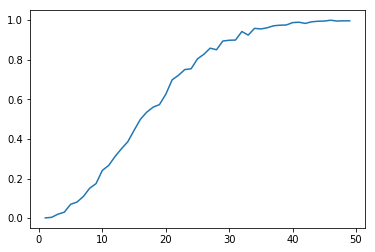

In [17]:
repeatProbability = [None]*50
iterations = 1000
for size in range(1,50):
    c = Counter()
    for i in range(1,iterations):
        repeats = countRepeats(sample(normalised['name'], normalised['probability'], size))
        c[repeats] += 1
    repeatProbability[size] = 1.0 - c.items()[0][1]/float(iterations)
    
plt.plot(repeatProbability)
plt.show()    

The curve is "wobbly" because of the smaller number of iterations, but it's easy to apply some smoothing mentally and see that the probability of repeated names approaches 1 very quickly.

For an organisation of 50 or more Software Engineers it's almost guaranteed there will be at least one duplicate name.

The half way point is around ~17 staff. If you have > 17 Software Engineers in a room there's a > 50% chance you'll have a duplicate name!